In [1]:
SAVE = True

VERSION = 'Empirical Covariance' #'Empirical Covariance'  # 'Pseudoinverse', 'Gaussian Obs Model'

x0 = 'all'
model = 'last'
binned_policy = 'ignore'

In [2]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import INTERACTIVE_NAMES, INTERVENTION_NAMES_EN
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

### Find the proximal effects of each intervention on each EMA, once with EMI in order, once with shuffled EMI

In [3]:
import pandas as pd
import numpy as np
import glob
from typing import Optional
from itertools import combinations
import os
import sys
sys.path.append('..')
import data_utils

# 'Positive affect', 'Negative affect', 'Self-esteem', 'Worrying', 'Activity level', 'Stress', 'Social isolation', 'Resilience', 'Emotion Regulation'

def get_proximal_effects_normal_and_shuffled(data: pd.DataFrame, sum_over_emas: bool=True, binned_policy: str='ignore', seed: Optional[int]=None, samples: int=100):
    
    if binned_policy == 'ignore':
        data.loc[data['Form'] == 'binned', LABELS] = np.nan
    elif binned_policy == 'drop':
        data = data.loc[data['Form'] != 'binned']
    diff = data.set_index(['Participant'], append=True)
    diff = data[LABELS].diff().shift(-1)
    diff[INTERACTIVE_NAMES] = data[INTERACTIVE_NAMES]

    EMI_occurrence = diff[INTERACTIVE_NAMES].sum().astype(int)
    EMI_occurrence[EMI_occurrence==0] = np.nan

    retain_indices = diff.notna().all(axis=1) & (diff[INTERACTIVE_NAMES].sum(axis=1) > 0)
    # diff = diff.dropna()
    # diff = diff.loc[diff[INTERACTIVE_NAMES].sum(axis=1)>0]
    diff = diff.loc[retain_indices]

    sum_effects = diff[LABELS].T.dot(diff[INTERACTIVE_NAMES])
    sum_effects = sum_effects.div(EMI_occurrence)

    list_sum_effects_shuffled = []
    shuffled_diff = diff.copy()
    for _ in range(samples):        
        shuffled_diff[INTERACTIVE_NAMES] = shuffled_diff[INTERACTIVE_NAMES].sample(frac=1, random_state=seed, replace=False).values
        sum_effects_shuffled = shuffled_diff[LABELS].T.dot(shuffled_diff[INTERACTIVE_NAMES])
        sum_effects_shuffled = sum_effects_shuffled.div(EMI_occurrence)
        if sum_over_emas:
            sum_effects_shuffled = sum_effects_shuffled.sum()
        list_sum_effects_shuffled.append(sum_effects_shuffled)
        if seed is not None:
            seed += 1
    
    if sum_over_emas:
        sum_effects = sum_effects.mean()
    
    return sum_effects, list_sum_effects_shuffled, EMI_occurrence

Calculate proximal effects

In [4]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
effects = []
emi_occurrences = []

SEED = 2
SAMPLES = 10000

for mrt in MRT:

    mrt_effects = []
    mrt_emi_occurrences = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating proximal effects for MRT {mrt}'):    
        pe, list_pe_shuffled, p_emi_occurrences = get_proximal_effects_normal_and_shuffled(df, binned_policy=binned_policy, seed=SEED, samples=SAMPLES)
        df_pe_shuffled = pd.concat(list_pe_shuffled, axis=1)
        mrt_effects.append(pd.concat([pe, df_pe_shuffled], axis=1, keys=['normal', 'shuffled'], names=['interventions']).T)
        mrt_emi_occurrences.append(p_emi_occurrences.to_frame().T)
    mrt_effects = pd.concat(mrt_effects, axis=0, keys=participants, names=['participant'])
    effects.append(mrt_effects)
    mrt_emi_occurrences = pd.concat(mrt_emi_occurrences, axis=0, keys=participants, names=['participant']).droplevel(-1)
    emi_occurrences.append(mrt_emi_occurrences)
effects = pd.concat(effects, axis=0, keys=MRT, names=['MRT']).swaplevel(1,3).swaplevel(1,2).sort_index()
emi_occurrences = pd.concat(emi_occurrences, axis=0, keys=MRT, names=['MRT']).sort_index()

Calculating proximal effects for MRT 3: 100%|██████████| 59/59 [18:59<00:00, 19.31s/it]


Plot normal and shuffled proximal effects

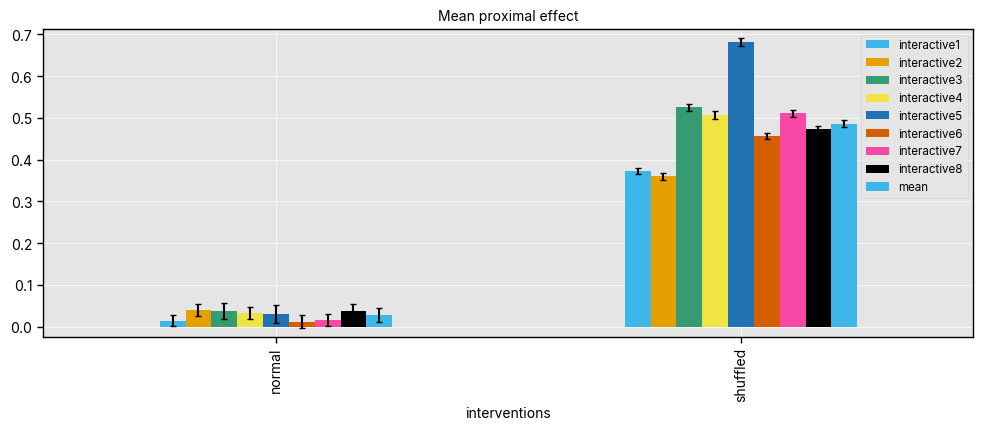

In [10]:
import matplotlib.pyplot as plt
import plotting_utils

with PaperStyle():

    mean_effects_per_mood = effects.groupby('interventions').mean()
    mean_effects_per_mood['mean'] = mean_effects_per_mood.mean(axis=1)
    sem_effects_per_mood = effects.groupby('interventions').sem()
    sem_effects_per_mood['mean'] = sem_effects_per_mood.mean(axis=1)

    fig, axes = plt.subplots(1, 1, figsize=(12,4))
    mean_effects_per_mood.plot(kind='bar', yerr=sem_effects_per_mood, ax=axes, title='Mean proximal effect')
    plotting_utils.adjust_ylim(axes)
    plt.show()

Load models and predict the proximal effects for every intervention time step with newest model ensemble

In [11]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from bptt.plrnn import PLRNN
from comparison_models.simple_models.models import KalmanFilter, VAR1

MRT = [2, 3]
plrnn_emi_cir = []
errors_loading_model = 0
ModelClass = PLRNN

for mrt in MRT:

    mrt_cir = []

    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    data_files = data_utils.get_data_files(test_data_dir, order_participants=True)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating Impulse Responses for MRT {mrt}'):
        model_dirs = models.get_latest_model_dirs(p)
        participant_cir = []
        for model_dir in model_dirs:
            model_cir = []
            args = utils.load_args(model_dir)
            model = ModelClass(args)
            model.init_from_model_path(model_dir)
            try:
                Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
            except:
                errors_loading_model += 1
                continue
            dim_x, dim_s = args['dim_x'], args['dim_s']
            
            initial_condition = tc.tensor(df[LABELS].to_numpy()).float()
            cir = tc.zeros(dim_s)
            for i in range(dim_s):
                perturbation = tc.zeros(dim_s).float()
                perturbation[i] = 1
                cir[i] = tc.nanmean(eval_reallabor_utils.impulse_response(model, perturbation, 1, cumulative=True, relative=True, x0=initial_condition, Gamma=Gamma, B=B))
            model_cir = pd.Series(cir.detach().numpy(), index=INTERACTIVE_NAMES)
            participant_cir.append(model_cir)
        if len(participant_cir) == 0:
            continue
        participant_cir_df = pd.concat(participant_cir, axis=1).T.mean(numeric_only=True)            
        # participant_cir_df = pd.concat([
        #                                 # participant_cir_df.groupby('x0').mean(numeric_only=True),            # Mean over all models
        #                                 participant_cir_df.loc[participant_cir_df['timestep']==participant_cir_df['timestep'].max()]  # just the last model
        #                                 ], 
        #                                 axis=0, keys=['all', 'last'], names=['model'])
        participant_cir_df['participant'] = int(p)
        mrt_cir.append(participant_cir_df)
    mrt_cir = pd.concat(mrt_cir, axis=1).T.set_index('participant')
    plrnn_emi_cir.append(mrt_cir)
plrnn_emi_cir = pd.concat(plrnn_emi_cir, axis=0, keys=MRT, names=['MRT']).sort_index()

if errors_loading_model > 0:
    print(f"Warning: {errors_loading_model} errors loading Gamma and B.")

Calculating Impulse Responses for MRT 3: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]

Plot group-wise rank correlations for normal and shuffled EMIs

In [12]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from weighted_correlation import weight_corr_for_dataframes, meta_spearman
from multiprocessing import Pool
from functools import partial

with PaperStyle():

    both_mrts_normal_correlations = []
    both_mrts_normal_groupwise_correlations = []
    both_mrts_shuffled_correlations = []
    both_mrts_shuffled_groupwise_correlations = []
    
    for m, mrt in enumerate(MRT):
        # fig, ax = plt.subplots(1, 1, figsize=(2,2))
        all_shuffled_correlations = []
        all_shuffled_groupwise_correlations = []
        this_cir = plrnn_emi_cir.loc[mrt]
        include_participants = this_cir.index.get_level_values('participant')
        this_effects = effects.loc[mrt]
        this_emi_occurrences = emi_occurrences.loc[mrt]

        normal_correlations = weight_corr_for_dataframes(this_cir, 
                                                         this_effects.loc[('normal', 0)].loc[include_participants], 
                                                         this_emi_occurrences.loc[include_participants], 
                                                         method='spearman', axis=1, B=100, alternative='greater', 
                                                         p_method='permutation', ci_type='percentile', clip_ci=True, nan_policy='omit')
        dropped = normal_correlations.loc[normal_correlations['statistic'].isna()].index.to_list()
        if len(dropped) > 0:
            print(f'Dropped participants {dropped}')

        normal_groupwise_correlation = pd.Series(meta_spearman(normal_correlations['statistic'].dropna(), None))

        both_mrts_normal_correlations.append(normal_correlations)
        both_mrts_normal_groupwise_correlations.append(normal_groupwise_correlation)
        
        def process_shuffle(shuffle_idx, this_cir, this_effects, this_emi_occurrences, include_participants):
            shuffled_correlations = weight_corr_for_dataframes(this_cir, 
                                  this_effects.loc[('shuffled', shuffle_idx)].loc[include_participants], 
                                  this_emi_occurrences.loc[include_participants], 
                                  method='spearman', axis=1, B=100, alternative='greater', 
                                  p_method='permutation', ci_type='percentile', clip_ci=True, nan_policy='omit')
            
            overall_effect = pd.Series(meta_spearman(shuffled_correlations['statistic'].dropna(), None))
            return shuffled_correlations['statistic'], overall_effect

        process_func = partial(process_shuffle, 
                       this_cir=this_cir, 
                       this_effects=this_effects, 
                       this_emi_occurrences=this_emi_occurrences,
                       include_participants=include_participants)

        n_workers = 64  # Set the number of workers here
        with Pool(processes=n_workers) as pool:
            results = list(tqdm(pool.imap(process_func, range(SAMPLES)), total=SAMPLES))

        all_shuffled_correlations = [r[0] for r in results]
        both_mrts_shuffled_correlations.append(all_shuffled_correlations)
        all_shuffled_groupwise_correlations = [r[1] for r in results]
        all_shuffled_groupwise_correlations = pd.concat(all_shuffled_groupwise_correlations, axis=1).T
        both_mrts_shuffled_groupwise_correlations.append(all_shuffled_groupwise_correlations)
        
        # all_shuffled_groupwise_correlations.T.plot(ax=ax, kind='boxplot', y='effect', ylabel=r'$\rho$', title=f'Sample {mrt}', label='group-wise correlation',
        #                                    yerr=[interventions_groupwise_correlations.loc['effect'] - interventions_groupwise_correlations.loc['ci_lower'], 
        #                                          interventions_groupwise_correlations.loc['ci_upper'] - interventions_groupwise_correlations.loc['effect']],
        #                                          legend=False)
        # plotting_utils.adjust_ylim(ax, top=0.03)

        # between_interventions_corr = interventions_correlations[0].corr(interventions_correlations[1], method='spearman')
        # print(f'Normal vs. shuffled meta correlation: {between_interventions_corr:.3f}')

        # fisher_correlations = []
        # for i in range(len(interventions_correlations)):
        #     fisher_correlations.append(np.arctanh(np.clip(interventions_correlations[i].astype(float), -0.999999, 0.999999)))
        # t_test_result = ttest_ind(fisher_correlations[0].dropna(), fisher_correlations[1].dropna(), equal_var=False)
        # print(f'T-test normal*shuffled: t({t_test_result.df:.0f})={t_test_result.statistic:.3f}, p={t_test_result.pvalue:.3f}')
        
        # if SAVE:
        #     plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_mrt{mrt}.svg'))
    # plt.tight_layout()
    # plt.show()

Dropped participants [73.0]


100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


Bootstrapped p-value for Sample 2: 0.001
Bootstrapped p-value for Sample 3: 0.001


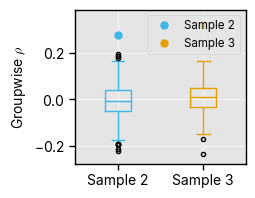

In [13]:
from plotting_styles import PaperStyle, colors
import plotting_utils 

with PaperStyle():
    fig, ax = plt.subplots(figsize=(2.2,2))
    for m, mrt in enumerate(MRT):
        both_mrts_shuffled_groupwise_correlations[m][['effect']].boxplot(ax=ax, positions=[m], color=colors.color_cycle[m], widths=0.3, flierprops={'markersize':3})
        # range = [both_mrts_shuffled_groupwise_correlations[m]['effect'].quantile(0.975), both_mrts_shuffled_groupwise_correlations[m]['effect'].quantile(0.025)]
        # axes[m].plot([1,1], range, 'k--')
        ax.plot([m], both_mrts_normal_groupwise_correlations[m]['effect'], 'o', label=f'Sample {mrt}', color=colors.color_cycle[m], markersize=5)
        ax.set(xticks=[0,1], xticklabels=['Sample 2', 'Sample 3'], ylabel=r'Groupwise $\rho$')
        ax.legend()
        plotting_utils.adjust_ylim(ax, bottom=0.05, top=0.1)

        bootstrapped_p_value = ((both_mrts_shuffled_groupwise_correlations[m]['effect'] >= both_mrts_normal_groupwise_correlations[m]['effect']).sum() + 1) / (SAMPLES + 1)
        print(f'Bootstrapped p-value for Sample {mrt}: {bootstrapped_p_value:.3f}')
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_shuffled_boxplot.svg'))
    plt.show()

In [14]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils
from weighted_correlation import weight_corr_for_dataframes, meta_spearman


with PaperStyle():
    
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    interventions_correlations = []
    interventions_groupwise_correlations = []
    this_cir = plrnn_emi_cir.droplevel('MRT')
    this_effects = effects.droplevel('MRT')
    this_emi_occurrences = emi_occurrences.droplevel('MRT').loc[this_cir.index]
    
    for interventions in ['normal', 'shuffled']:
        correlations = weight_corr_for_dataframes(this_cir, this_effects.loc[interventions].loc[this_cir.index], this_emi_occurrences, 
                                                    method='spearman', axis=1, B=100, alternative='greater', 
                                                    p_method='permutation', ci_type='percentile', clip_ci=True, nan_policy='omit')
    
        correlations['signif_color'] = correlations['p_value'].apply(lambda p: 'C0' if p<0.05 else 'C1')
        interventions_correlations.append(correlations['statistic'])
        dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()
        if len(dropped) > 0:
            print(f'Dropped participants {dropped} in {interventions} condition')

        overall_effect = pd.Series(meta_spearman(correlations['statistic'].dropna(), None))
        interventions_groupwise_correlations.append(overall_effect)

    interventions_groupwise_correlations = pd.concat(interventions_groupwise_correlations, axis=1, keys=['normal', 'shuffled'])
    interventions_groupwise_correlations.T.plot(ax=ax, kind='bar', y='effect', ylabel=r'$\rho$', title=f'All Samples', label='group-wise correlation',
                                        yerr=[interventions_groupwise_correlations.loc['effect'] - interventions_groupwise_correlations.loc['ci_lower'], 
                                                interventions_groupwise_correlations.loc['ci_upper'] - interventions_groupwise_correlations.loc['effect']],
                                                legend=False)
    plotting_utils.adjust_ylim(ax, top=0.03)

    between_interventions_corr = interventions_correlations[0].corr(interventions_correlations[1], method='spearman')
    print(f'Normal vs. shuffled meta correlation: {between_interventions_corr:.3f}')

    fisher_correlations = []
    for i in range(len(interventions_correlations)):
        fisher_correlations.append(np.arctanh(np.clip(interventions_correlations[i].astype(float), -0.999999, 0.999999)))
    t_test_result = ttest_ind(fisher_correlations[0].dropna(), fisher_correlations[1].dropna(), equal_var=False, alternative='greater')
    print(f'T-test normal*shuffled: t({t_test_result.df:.0f})={t_test_result.statistic:.3f}, p={t_test_result.pvalue:.3f}')
    
    # if SAVE:
    #     plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_mrt{mrt}.svg'))
    plt.show()

KeyError: "Index([ 12.0,  13.0,  14.0,  15.0,  16.0,  18.0,  19.0,  21.0,  22.0,  23.0,\n       ...\n       263.0, 264.0, 265.0, 266.0, 267.0, 269.0, 270.0, 271.0, 272.0, 301.0],\n      dtype='float32', name='participant', length=114) not in index"